In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm_notebook
import  matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix , accuracy_score, plot_confusion_matrix, ConfusionMatrixDisplay

np.random.seed(1234)

In [0]:
# choose GPU/CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [0]:
import torchvision
fmnist_train = torchvision.datasets.FashionMNIST('/content/', download=True)
fmnist_test  = torchvision.datasets.FashionMNIST('/content/', download=True, train=False)

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw
Processing...
Done!


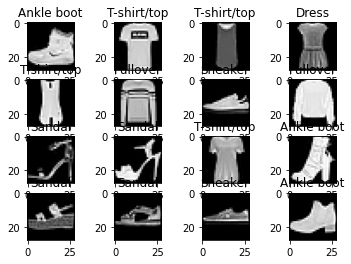

In [0]:
for i in range(16):
    f, t = fmnist_train[i]
    plt.subplot(4, 4, i+1)
    plt.imshow(f, cmap='gray')
    plt.title(fmnist_train.classes[t])

In [0]:
class FMNIST_DS(Dataset):
    def __init__(self, ds):
        super().__init__()
        self.ds = ds
        self.len = len(ds)

    def __getitem__(self, index):
        image , target = self.ds[index] 

        feature = np.array(image).flatten()/256.0
        feature = torch.tensor(feature , dtype=torch.float)

        target  = torch.tensor(target)
        
        return  feature, target
       
    def __len__(self):
        return self.len

In [0]:
train_ds = FMNIST_DS(fmnist_train)
test_ds  = FMNIST_DS(fmnist_test)

In [0]:
f , t = next(iter(train_ds))
f.shape , t.shape

(torch.Size([784]), torch.Size([]))

In [0]:
batch_size = 100
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 1)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(train_dl))
fs.shape , ts.shape

(torch.Size([100, 784]), torch.Size([100]))

In [0]:
class MLP2(nn.Module):
    def __init__(self, input_dim = 784, hidden1 = 1000, hidden2 = 100, output_dim = 10):
        super().__init__()
        self.n = input_dim
        self.hidden1 = hidden1
        self.hidden2 = hidden2
        self.o = output_dim

        self.fc1  = nn.Linear(self.n, self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2  = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3  = nn.Linear(self.hidden2, self.o)
        self.act3 = nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.act2(out)
        out = self.fc3(out)
        out = self.act3(out)

        return out

In [0]:
net = MLP2().to(device)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(),lr=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9999)

In [0]:
def plt_conf_mat(y_true , y_pred, labels, normalize = 'true'  , include_values = True, 
                 xticks_rotation='horizontal',
                 values_format=None,
                 cmap='winter'):
    plt.figure(figsize=[9, 9])
    ax = plt.subplot(1, 1, 1)
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format)

In [0]:
def train_step(model, train_dl, criterion, optimizer):
    total_loss = 0.0
    total_correct = 0
    
    # for i, (train_inputs, train_labels) in tqdm_notebook(enumerate(train_dl), 
    #                                                      desc='Training', 
    #                                                      total=len(train_dl)):
    for i, (train_inputs, train_labels) in enumerate(train_dl):
        # move to device
        train_inputs , train_labels = train_inputs.to(device) , train_labels.to(device)

        optimizer.zero_grad()
        output = model(train_inputs)
        loss = criterion(output, train_labels)
        loss.backward()     
        optimizer.step()
        total_loss += loss.item()
        with torch.no_grad():
            mx , argmx = torch.max(output, dim=1)
            total_correct += torch.sum(argmx == train_labels).item()/len(argmx)

    return total_loss/len(train_dl), total_correct/len(train_dl)


def validate_step(model, valid_dl, criterion):
    total_loss = 0.0
    total_correct = 0
    with torch.no_grad():
        # for i, (test_inputs, test_labels) in tqdm_notebook(enumerate(valid_dl), 
        #                                                 desc='Validation', 
        #                                                 total=len(valid_dl)):
        for i, (test_inputs, test_labels) in enumerate(valid_dl):
            # move to device
            test_inputs , test_labels = test_inputs.to(device) , test_labels.to(device)

            output = model(test_inputs)
            loss = criterion(output, test_labels)
            total_loss += loss.item()

            mx , argmx = torch.max(output, dim=1)
            total_correct += torch.sum(argmx == test_labels).item()/len(argmx)

    return total_loss/len(test_dl), total_correct/len(test_dl)


def train(model, train_dl, valid_dl, criterion, optimizer, scheduler, num_epochs, train_loss, test_loss, train_acc, test_acc):
    
    best_wts = None
    best_loss = float('inf')

    for epoch in range(num_epochs):

        ## perform one epoch of training and validation
        trn_loss, trn_acc = train_step(model, train_dl, criterion, optimizer)
        val_loss, val_acc = validate_step(model, valid_dl, criterion)
        scheduler.step()

        train_loss += [trn_loss]
        test_loss  += [val_loss]
        train_acc  += [trn_acc ]
        test_acc   += [val_acc ]

#         # save weights
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_wts = model.state_dict().copy()
            
# #             torch.save(best_wts, 'models/lstm-{}-{}-{}-{}-{}-{}-{:.5f}.pth'.format(
# #                 epoch, max_len, min_count, model.embed_size, model.hidden_size, model.num_layers, best_acc))

        print(f'[Epoch:{epoch+1}/{num_epochs}] Training Loss: %.4f| Testing Loss: %.4f| Training ACC: %.4f| Testing ACC: %.4f|'
              % (trn_loss* 10000, val_loss* 10000 , trn_acc*100, val_acc*100))

    # model.load_state_dict(best_wts)
    return train_loss, test_loss, train_acc, test_acc

In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(net, train_dl, test_dl, criterion, optimizer, scheduler, 100, train_loss, test_loss, train_acc, test_acc)

Text(0.5, 1.0, 'trianing loss: 1000, 100')

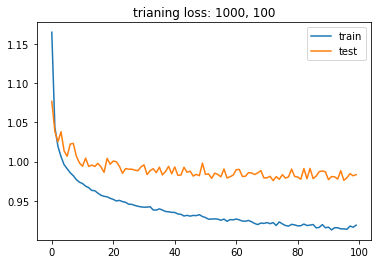

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: 1000, 100')

Text(0.5, 1.0, 'trianing acc: 1000, 100')

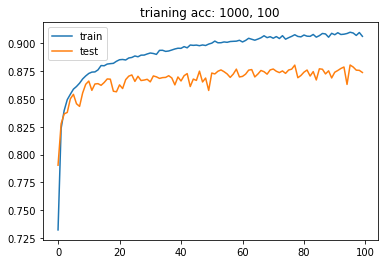

In [0]:
plt.plot([i for i in train_acc] , label='train')
plt.plot([i for i in test_acc ] , label ='test')
plt.legend()
plt.title('trianing acc: 1000, 100')

In [0]:
test_dl = DataLoader(test_ds , batch_size=len(test_ds) , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(test_dl))
fs , ts = fs.to(device) , ts.to(device)

output = net(fs)
mx , argmx = torch.max(output, dim=1)


torch.Size([10000])

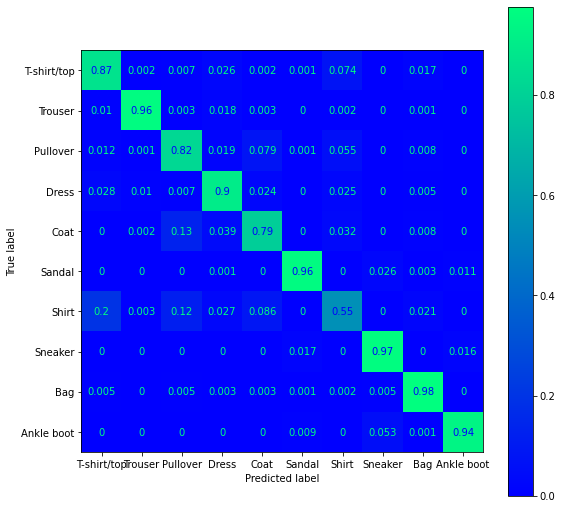

In [0]:
plt_conf_mat(ts.to('cpu'), argmx.to('cpu'), fmnist_test.classes)

In [0]:
accuracy_score(ts.to('cpu'), argmx.to('cpu'))

0.8736

500 - 100 - 10

In [0]:
net = MLP2(hidden1=500).to(device)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(),lr=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9999)


In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(net, train_dl, test_dl, criterion, optimizer, scheduler, 30, train_loss, test_loss, train_acc, test_acc)

Text(0.5, 1.0, 'trianing loss: 1000, 100')

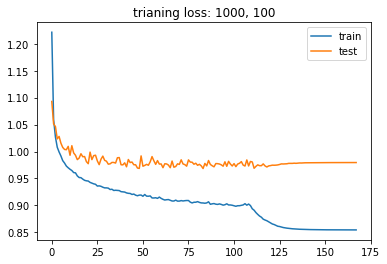

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: 1000, 100')

Text(0.5, 1.0, 'trianing acc: 1000, 100')

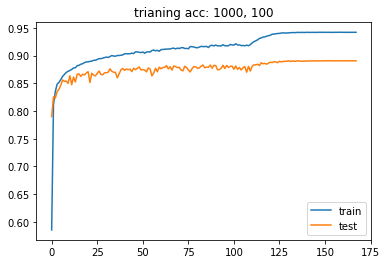

In [0]:
plt.plot([i for i in train_acc] , label='train')
plt.plot([i for i in test_acc ] , label ='test')
plt.legend()
plt.title('trianing acc: 1000, 100')

In [0]:
test_dl = DataLoader(test_ds , batch_size=len(test_ds) , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(test_dl))
fs , ts = fs.to(device) , ts.to(device)

output = net(fs)
mx , argmx = torch.max(output, dim=1)

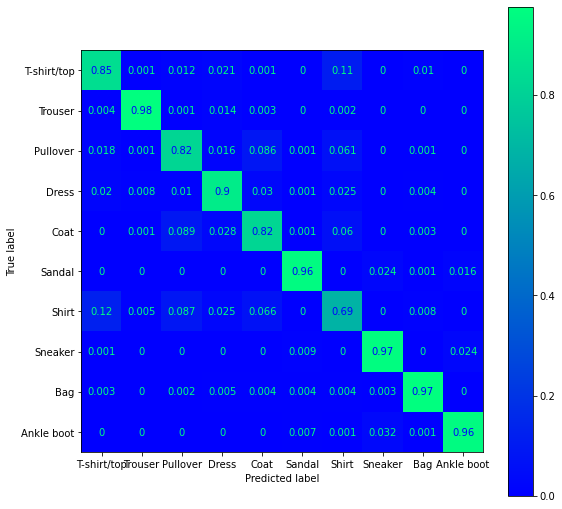

In [0]:
plt_conf_mat(ts.to('cpu'), argmx.to('cpu'), fmnist_test.classes)

In [0]:
accuracy_score(ts.to('cpu'), argmx.to('cpu'))

0.8905

500 - 200 - 10

In [0]:
net = MLP2(hidden1=500, hidden2=200).to(device)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(),lr=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.999)


In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(net, train_dl, test_dl, criterion, optimizer, scheduler, 40, train_loss, test_loss, train_acc, test_acc)

Text(0.5, 1.0, 'trianing loss: 1000, 100')

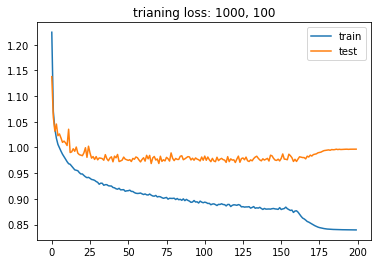

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: 1000, 100')

Text(0.5, 1.0, 'trianing acc: 1000, 100')

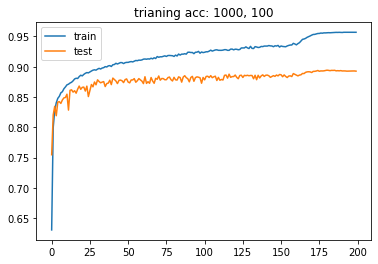

In [0]:
plt.plot([i for i in train_acc] , label='train')
plt.plot([i for i in test_acc ] , label ='test')
plt.legend()
plt.title('trianing acc: 1000, 100')

In [0]:
test_dl = DataLoader(test_ds , batch_size=len(test_ds) , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(test_dl))
fs , ts = fs.to(device) , ts.to(device)

output = net(fs)
mx , argmx = torch.max(output, dim=1)

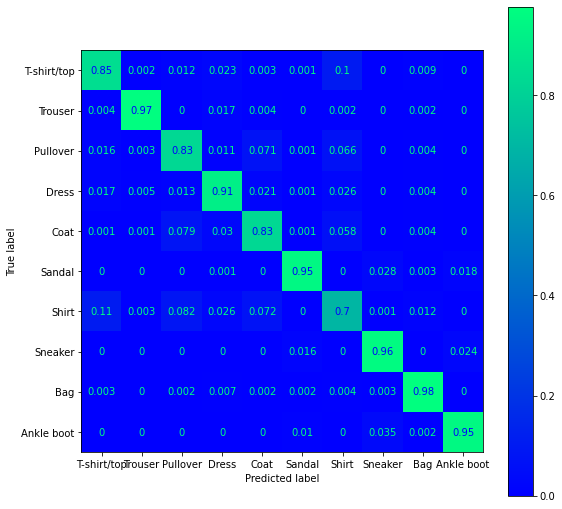

In [0]:
plt_conf_mat(ts.to('cpu'), argmx.to('cpu'), fmnist_test.classes)

In [0]:
accuracy_score(ts.to('cpu'), argmx.to('cpu'))

0.8926

# Batch size

batch size = 32

In [0]:
batch_size = 32
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 1)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 1)

In [0]:
net = MLP2(hidden1=500, hidden2=200).to(device)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(),lr=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)


In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(net, train_dl, test_dl, criterion, optimizer, scheduler, 60, train_loss, test_loss, train_acc, test_acc)

Text(0.5, 1.0, 'trianing loss: 1000, 100')

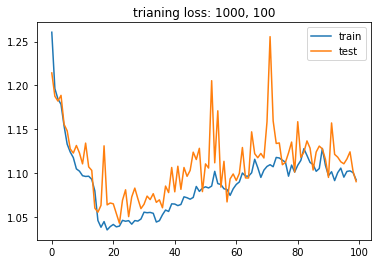

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: 1000, 100')

Text(0.5, 1.0, 'trianing acc: 1000, 100')

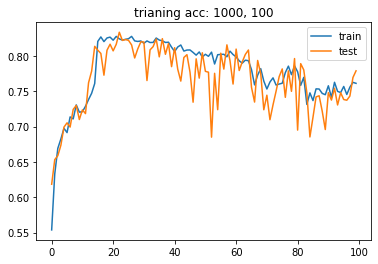

In [0]:
plt.plot([i for i in train_acc] , label='train')
plt.plot([i for i in test_acc ] , label ='test')
plt.legend()
plt.title('trianing acc: 1000, 100')

In [0]:
test_dl = DataLoader(test_ds , batch_size=len(test_ds) , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(test_dl))
fs , ts = fs.to(device) , ts.to(device)

output = net(fs)
mx , argmx = torch.max(output, dim=1)

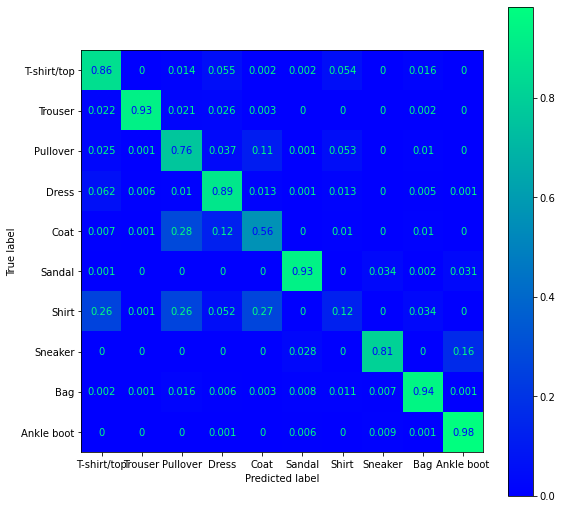

In [0]:
plt_conf_mat(ts.to('cpu'), argmx.to('cpu'), fmnist_test.classes)

In [0]:
accuracy_score(ts.to('cpu'), argmx.to('cpu'))

0.779

batch size = 64

In [0]:
batch_size = 64
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 1)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 1)

In [0]:
net = MLP2(hidden1=500, hidden2=200).to(device)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(),lr=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)


In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(net, train_dl, test_dl, criterion, optimizer, scheduler, 100, train_loss, test_loss, train_acc, test_acc)

Text(0.5, 1.0, 'trianing loss: 1000, 100')

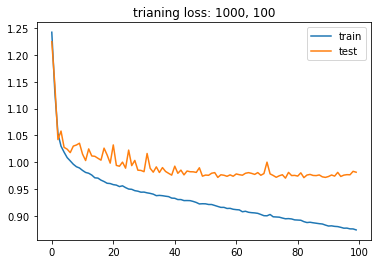

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: 1000, 100')

Text(0.5, 1.0, 'trianing acc: 1000, 100')

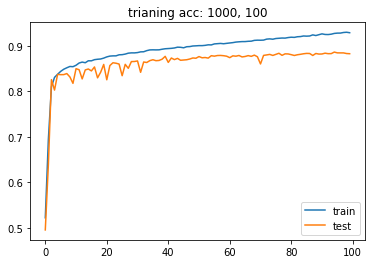

In [0]:
plt.plot([i for i in train_acc] , label='train')
plt.plot([i for i in test_acc ] , label ='test')
plt.legend()
plt.title('trianing acc: 1000, 100')

In [0]:
test_dl = DataLoader(test_ds , batch_size=len(test_ds) , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(test_dl))
fs , ts = fs.to(device) , ts.to(device)

output = net(fs)
mx , argmx = torch.max(output, dim=1)

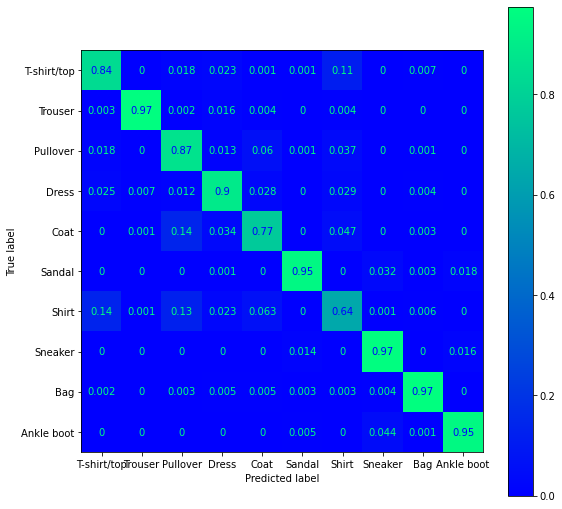

In [0]:
plt_conf_mat(ts.to('cpu'), argmx.to('cpu'), fmnist_test.classes)

In [0]:
accuracy_score(ts.to('cpu'), argmx.to('cpu'))

0.8828

batch size = 256

In [0]:
batch_size = 256
train_dl = DataLoader(train_ds , batch_size=batch_size , shuffle= True , num_workers = 1)
test_dl = DataLoader(test_ds , batch_size=batch_size , shuffle= False , num_workers = 1)

In [0]:
net = MLP2(hidden1=500, hidden2=200).to(device)

In [0]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(net.parameters(),lr=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.99)


In [0]:
train_loss , test_loss, train_acc, test_acc = [], [], [], []

In [0]:
train_loss, test_loss, train_acc, test_acc = train(net, train_dl, test_dl, criterion, optimizer, scheduler, 100, train_loss, test_loss, train_acc, test_acc)

Text(0.5, 1.0, 'trianing loss: 1000, 100')

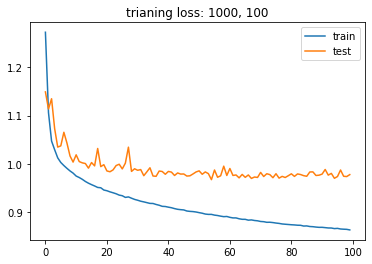

In [0]:
plt.plot([i for i in train_loss] , label='train')
plt.plot([i for i in test_loss ] , label ='test')
plt.legend()
plt.title('trianing loss: 1000, 100')

Text(0.5, 1.0, 'trianing acc: 1000, 100')

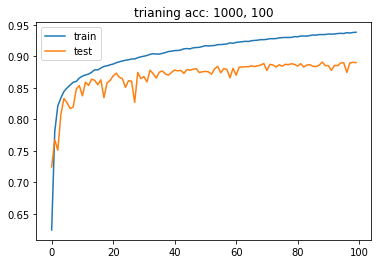

In [0]:
plt.plot([i for i in train_acc] , label='train')
plt.plot([i for i in test_acc ] , label ='test')
plt.legend()
plt.title('trianing acc: 1000, 100')

In [0]:
test_dl = DataLoader(test_ds , batch_size=len(test_ds) , shuffle= False , num_workers = 1)

In [0]:
fs , ts = next(iter(test_dl))
fs , ts = fs.to(device) , ts.to(device)

output = net(fs)
mx , argmx = torch.max(output, dim=1)

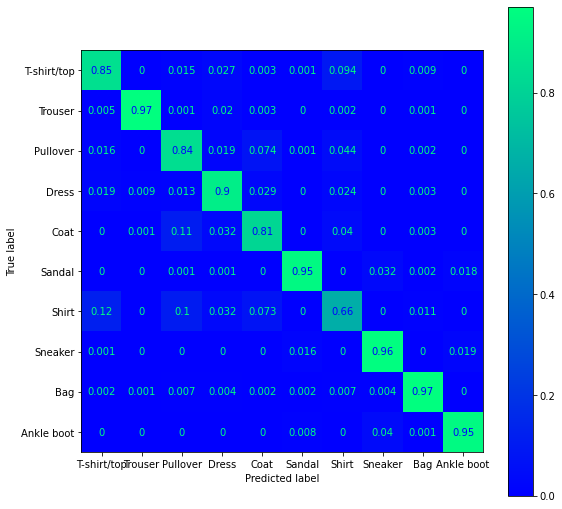

In [0]:
plt_conf_mat(ts.to('cpu'), argmx.to('cpu'), fmnist_test.classes)

In [0]:
accuracy_score(ts.to('cpu'), argmx.to('cpu'))

0.8873